In [38]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models\shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models\dlib_face_recognition_resnet_model_v1.dat')

In [39]:
# find_faces fuction's param should be rgb img file
def find_faces(img): 
    dets = detector(img, 1)

    # 얼굴을 하나도 찾지 못했을 경우 return 빈 배열 
    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    # 결과물 저장할 변수들
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=int)

    for k, d in enumerate(dets): 
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        # 랜드마크 구하기 
        shape = sp(img, d)

    # numpy array 로 바꾸기 
    for i in range(0, 68): 
        shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

    shapes.append(shape)

    return rects, shapes, shapes_np

# 68개의 점 -> 128개의 벡터(거리로 유사도 측정함)
def encode_faces(img, shapes): 
    face_descriptors = []
    for shape in shapes: 
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))
    
    return np.array(face_descriptors)

In [40]:
# 베이스가 되는 사진 
img_path = {
    'seo': 'seo\originseo.jpg'
}

descs = {
    'seo': None
}

for name, img_path in img_path.items(): 
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    _, img_shapes, img_shapes_np = find_faces(img_rgb)
    descs[name] = encode_faces(img_rgb, img_shapes)[0]

np.save('descs/descs.npy', descs)
# print(descs)

In [41]:
img_bgr = cv2.imread('seo/seo3.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, a = find_faces(img_rgb)
descriptors = encode_faces(img_rgb, shapes)
print(len(a))

1


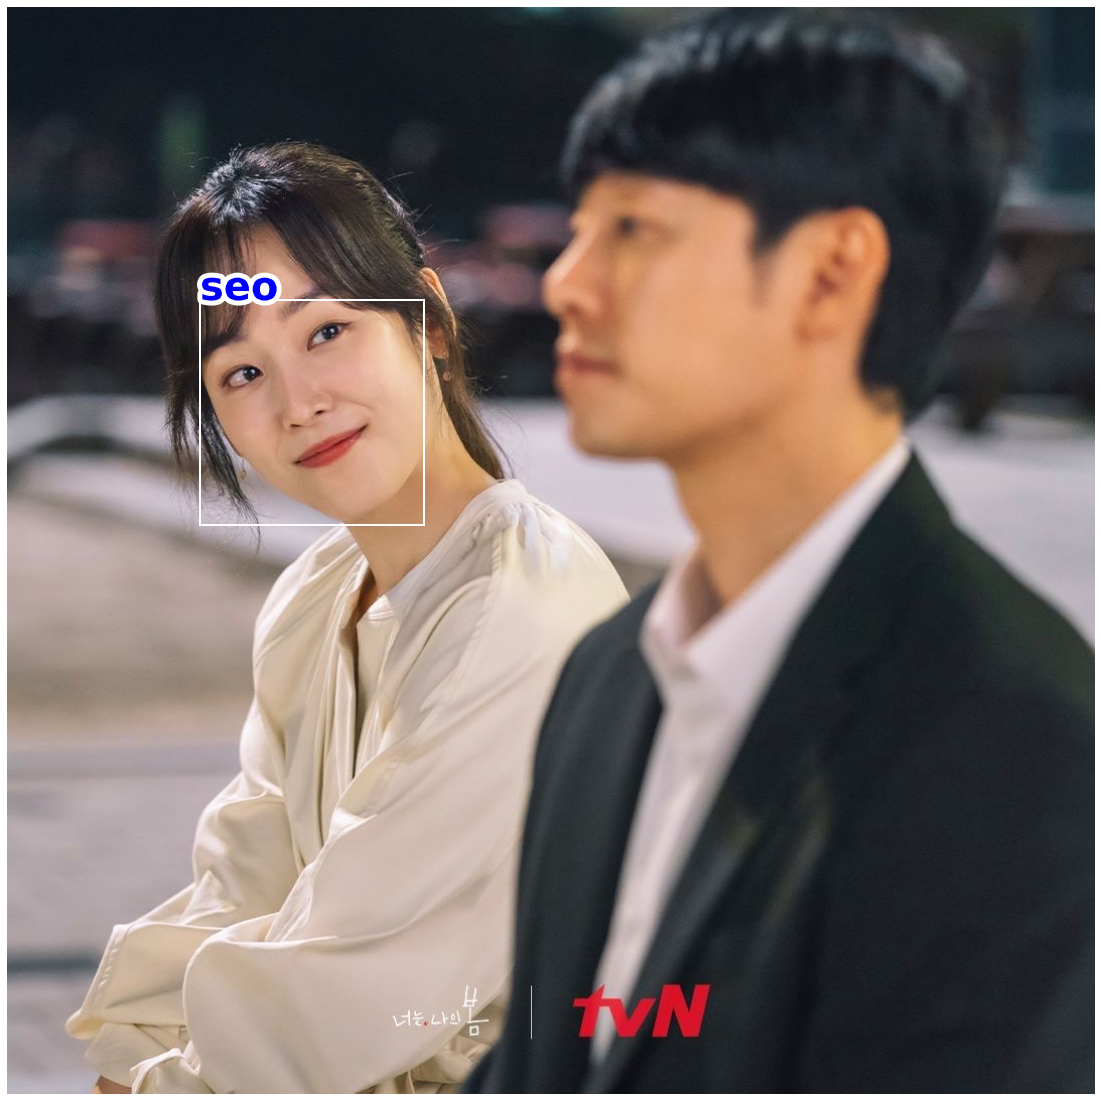

In [42]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    found = False

    for name, saved_desc in descs.items(): 
        # 유클리드 distance (벡터거리를 구하는 함수)
        dist = np.linalg.norm([desc] - saved_desc, axis=1)

        if dist < 0.6: 
            found = True

            text = ax.text(rects[i][0][0], rects[i][0][1], name, 
                color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])
            rect = patches.Rectangle(rects[i][0], 
                rects[i][1][1] - rects[i][0][1], rects[i][1][0] - rects[i][0][0], 
                linewidth=2, edgecolor = 'w', facecolor='none')
            ax.add_patch(rect)
            break
    if not found: 
        ax.text(rects[i][0][0], rects[i][0][1], 'unknown', 
            color='r', fontsize=20, fontweight='bold')
        rect = patches.Rectangle(rects[i][0], 
            rects[i][1][1] - rects[i][0][1], rects[i][1][0] - rects[i][0][0], 
            linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
# plt.savefig('result/output.png')
plt.show()